In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics, dummy, linear_model, ensemble
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

## Part 1

## Data Wrangling

In [2]:
#load the data and insepect the first few rows

path = 'data/data_science_assignment.csv'

df = pd.read_csv(path)

df.head()

,Success,Model_B,Date,X1,X2,X3,X4
0,0,0.320440,2018-07,0,-0.897088,0.804294,0.707665
1,0,0.491581,2018-09,1,-0.328084,-0.332256,-0.340870
2,0,0.085481,2015-08,0,1.272140,2.243532,0.815581
3,1,0.839927,2017-07,1,0.290594,-1.161187,-0.881761
4,0,0.146804,2018-09,0,-0.307462,1.161276,1.597084


In [3]:
#check for nulls and inspect data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Success  6000 non-null   int64  
 1   Model_B  6000 non-null   float64
 2   Date     6000 non-null   object 
 3   X1       6000 non-null   int64  
 4   X2       6000 non-null   float64
 5   X3       6000 non-null   float64
 6   X4       6000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 328.2+ KB


In [4]:
#convert the Date field from object to datetime
df.Date = pd.to_datetime(df.Date)

In [5]:
#inspect value ranges, summary stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Success,6000.0,0.155667,0.362569,0.000000,0.000000,0.000000,0.000000,1.000000
Model_B,6000.0,0.493951,0.209031,0.021030,0.330084,0.491583,0.657086,0.988474
X1,6000.0,0.502167,0.500037,0.000000,0.000000,1.000000,1.000000,1.000000
X2,6000.0,-0.003326,1.004197,-3.612620,-0.702663,-0.001634,0.685290,3.896294
X3,6000.0,0.007374,1.012626,-4.860280,-0.673058,0.015458,0.681624,3.852129
X4,6000.0,0.015992,1.013181,-4.416066,-0.662022,0.020163,0.681972,3.641890


0    0.844333
1    0.155667
Name: Success, dtype: float64

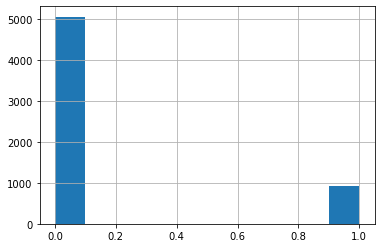

In [6]:
#the Success field appears skewed (most campaigns appear ineffective)
df.Success.hist();
df.Success.value_counts(normalize=True)

The classes are imbalanced but the imbalance is insignificant enough that it is likely unnecessary to take special steps (such as under or oversampling) to address the imbalance.

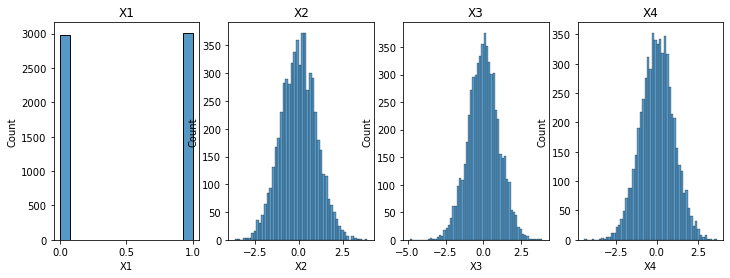

In [7]:
#inspect the distributions for the new features (X1 - X4)
features = ['X' + str(i) for i in range(1,5)]

fig, ax = plt.subplots(1,4, figsize=(12,4))

for i, feature in enumerate(features):
    sns.histplot(data = df, x = feature, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(feature)

X1's values are distrubted evenly between 0 and 1.

X2 - X4 all appear normally distributed with their mean centred around 0. 

There do not appear to be any significant outliers.

## Exploratory Data Analysis

In [8]:
#overall success rate
success_rate = df['Success'].sum()/df['Success'].count()
success_rate

0.15566666666666668

**Relationships between predictors (X1-X4) and the target feature (Success)**

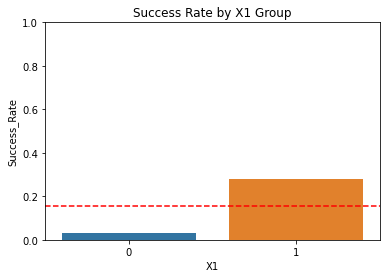

In [9]:
#X1

#group the data by X1
df_success_X1 = df.groupby('X1').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_X1['Success_Rate'] = df_success_X1.Success / df_success_X1.Count


#inspect the different success rates
sns.barplot(x='X1', y='Success_Rate', data=df_success_X1);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by X1 Group')

#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

Success rate tend to be much higher when X1 is true.

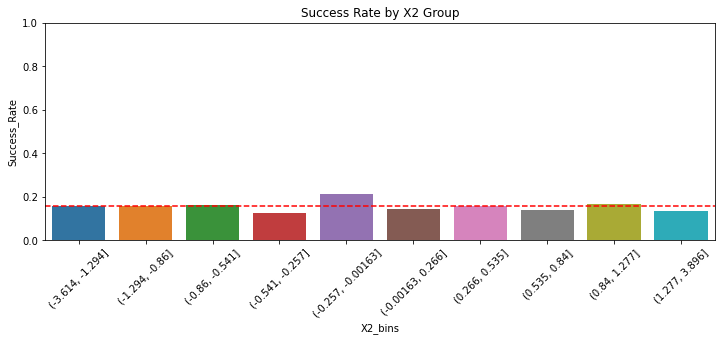

In [10]:
#X2

#bin the X2 data for analysis
df['X2_bins'] = pd.qcut(df['X2'],10)

#group the data by X2 bins
df_success_X2 = df.groupby('X2_bins').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_X2['Success_Rate'] = df_success_X2.Success / df_success_X2.Count

#plot the success rate by X2 range
plt.subplots(figsize=(12,4))
sns.barplot(x='X2_bins', y='Success_Rate', data=df_success_X2);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by X2 Group')
for label in plt.gca().get_xticklabels():
        label.set_rotation(45) 
        
#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

#drop the temporary X2_bins feature
df.drop(columns=['X2_bins'], inplace=True)

X2 does not appear to have a significant impact on success rate. However, for now we can keep X2 as we can not know for sure that it will not be beneficial during the modeling stage.

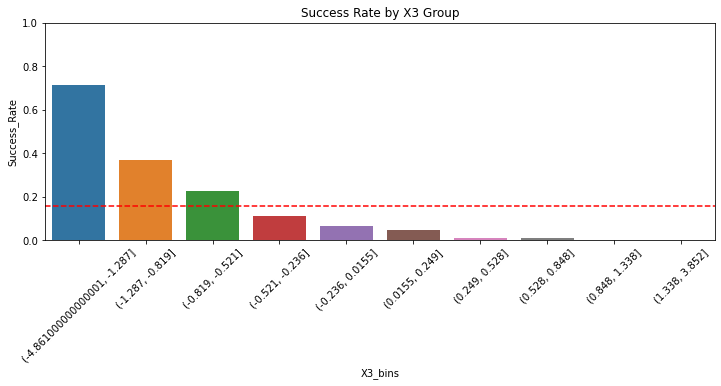

In [11]:
#X3

#bin the X3 data for analysis
df['X3_bins'] = pd.qcut(df['X3'],10)

#group the data by X3 bins
df_success_X3 = df.groupby('X3_bins').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_X3['Success_Rate'] = df_success_X3.Success / df_success_X3.Count

#plot the success rate by X3 range
plt.subplots(figsize=(12,4))
sns.barplot(x='X3_bins', y='Success_Rate', data=df_success_X3);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by X3 Group')
for label in plt.gca().get_xticklabels():
        label.set_rotation(45) 
        
#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

#drop the temporary X3_bins feature
df.drop(columns=['X3_bins'], inplace=True)

X3 appears to be a useful feature for predicting success. The success rate is much higher at lower X3 levels

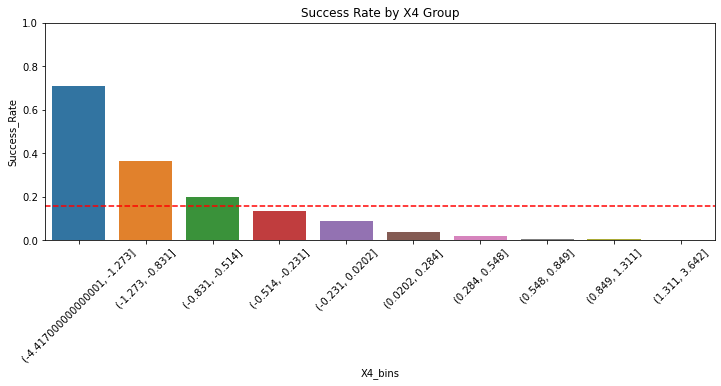

In [12]:
#X4

#bin the X4 data for analysis
df['X4_bins'] = pd.qcut(df['X4'],10)

#group the data by X4 bins
df_success_X4 = df.groupby('X4_bins').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_X4['Success_Rate'] = df_success_X4.Success / df_success_X4.Count

#plot the success rate by X4 range
plt.subplots(figsize=(12,4))
sns.barplot(x='X4_bins', y='Success_Rate', data=df_success_X4);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by X4 Group')
for label in plt.gca().get_xticklabels():
        label.set_rotation(45) 
        
#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

#drop the temporary X4_bins feature
df.drop(columns=['X4_bins'], inplace=True)

X4 appears to be a useful feature for predicting success. The success rate is much higher at lower X4 levels. However the X3 and X4 trends appear very similar so it is likely worth check for multicollinearity in order to remove redundant features.

## Correlation Heatmap

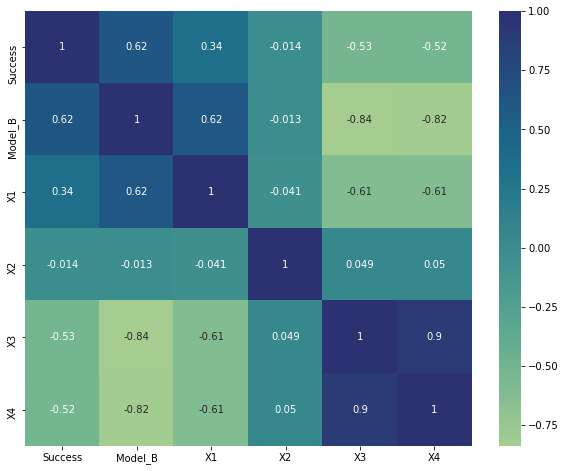

In [13]:
#heatmap to inspect correlations 
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='crest', annot=True);

The correlation heatmap agrees with the above analysis:
* X1, X3, and X4 all have a large enough (positive or negative) correlation with Success that we can expect reasonable predictive power
* X2 has much lower correlation with Success and likely won't have much predictive power
* X3 and X4 are highly correlated and likely redundant - one of these features will likely be removed when multicollinear features are filtered out. Another option would be to combine these two features into a single feature.
* X1 also has a moderately strong (negative) correlation with X3 and X4.

## Feature Engineering

**It appears that we only have date data at a monthly granularity. Therefore, data cannot be inspected at a finer grained level than the month**

In [14]:
#check the day of the month
df.Date.dt.day.value_counts()

1    6000
Name: Date, dtype: int64

**We can derive the month of the year from the date to inspect seasonality**

In [15]:
#month
df['month'] = df.Date.dt.month
df.month

0        7
1        9
2        8
3        7
4        9
        ..
5995     2
5996    11
5997     4
5998    12
5999     4
Name: month, Length: 6000, dtype: int64

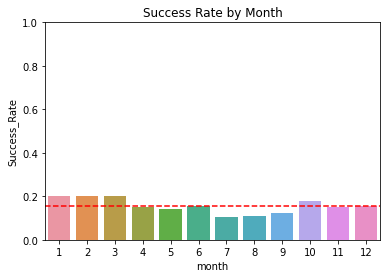

In [16]:
#look at relationshp between month and success

#group the data by month
df_success_month = df.groupby('month').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_month['Success_Rate'] = df_success_month.Success / df_success_month.Count


#inspect the different success rates
sns.barplot(x='month', y='Success_Rate', data=df_success_month);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by Month')

#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

Success rates are highest in the 1st quarter of the year. They tend to be lowest in the 3rd quarter and moderate in quarters 2 and 4. A feature can be created to reflect the quarter.

In [17]:
#function to map month to quarter
def map_month_quarter(row):
    if row['month'] <= 3:
        return 'Q1'
    elif row['month'] >3 and row['month'] <=6:
        return 'Q2'
    elif row['month'] >6 and row['month'] <=9:
        return 'Q3'
    else:
        return 'Q4'

In [18]:
#map each month to a quarter
df['quarter'] = df.apply(lambda row : map_month_quarter(row), axis=1)

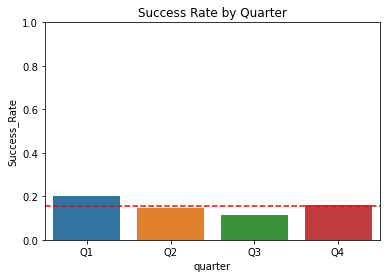

In [19]:
#look at relationshp between quarter and success

#group the data by quarter
df_success_quarter = df.groupby('quarter').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_quarter['Success_Rate'] = df_success_quarter.Success / df_success_quarter.Count


#inspect the different success rates
sns.barplot(x='quarter', y='Success_Rate', data=df_success_quarter);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by Quarter')

#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

In [20]:
#look at time between the Date value and latest date (used to represent the current date)
current_date = df.Date.max()
df['days_since_date'] = (current_date - df.Date).dt.days
df['days_since_date'] = df['days_since_date'].astype(np.int64) 

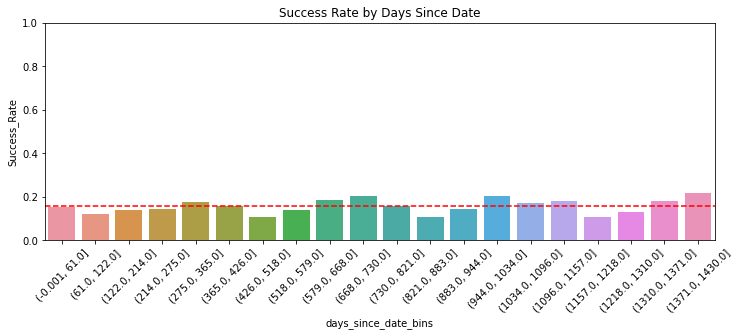

In [21]:
#inspect the relationship between days since the event and success

#bin the days_since_date data for analysis
df['days_since_date_bins'] = pd.qcut(df['days_since_date'],20)

#group the data by X4 bins
df_success_days_since_date = df.groupby('days_since_date_bins').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_days_since_date['Success_Rate'] = df_success_days_since_date.Success / df_success_days_since_date.Count

#plot the success rate by X4 range
plt.subplots(figsize=(12,4))
sns.barplot(x='days_since_date_bins', y='Success_Rate', data=df_success_days_since_date);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by Days Since Date')
for label in plt.gca().get_xticklabels():
        label.set_rotation(45) 
        
#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

#drop the temporary X4_bins feature
df.drop(columns=['days_since_date_bins'], inplace=True)

It appears that the Days since the event value is capturing some seasonality in success rate.

## Drop Unneeded Columns

In [22]:
#drop the Date column
df.drop(columns=['Date'],inplace=True)

## Part 2

## Preprocessing

In [23]:
#set a value from random state to ensure repeatability
random_state=42

In [24]:
#separate X (feature matrix) and y (target vector)
X = df.drop(columns=['Success'])
y = df.Success

In [25]:
#train/test split
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, train_size=0.7, stratify=y, random_state=random_state)

**Categorical Encoding**

In [26]:
#encode categorical columns using One Hot Encoding

#get the categorical columns from the training data
categorical_columns = ['month', 'quarter']
df_categorical = X_train[categorical_columns]

#initialize the One Hot encoder
encoder = preprocessing.OneHotEncoder(sparse=False)

#fit the encoder to the training data, encode the training data, add the encoded columns to the dataframe
encoded_cols = encoder.fit_transform(df_categorical)
df_encoded = pd.DataFrame(encoded_cols, 
                          columns=encoder.get_feature_names(categorical_columns),
                         index=X_train.index)
X_train = pd.concat([X_train,df_encoded], axis=1)

#drop the original categorical columns
X_train.drop(columns=categorical_columns, inplace=True)


#get the categorical columns from the test data
df_categorical = X_test[categorical_columns]

#encode the test data using the encoder that was fitted to the training data
encoded_cols = encoder.transform(df_categorical)
df_encoded = pd.DataFrame(encoded_cols, 
                          columns=encoder.get_feature_names(categorical_columns),
                         index=X_test.index)
X_test = pd.concat([X_test,df_encoded], axis=1)

#drop the original categorical columns
X_test.drop(columns=categorical_columns, inplace=True)

**Typically the numerical columns would be scaled. However, this data already appears to have been scaled so the scaling step can be skipped**

## Multicollinearity

**Remove the Feature With the Greatest VIF Until All Features Have VIF < 2:**

In [27]:
#We want to keep the Model_B feature. Therefore, we will remove it from the dataframe, remove multicollinear features,
#and then add Model_B back to the dataframe.
X_train_model_B = X_train['Model_B']
X_test_model_B = X_test['Model_B']

X_train.drop(columns=['Model_B'], inplace=True)
X_test.drop(columns=['Model_B'], inplace=True)

In [28]:
#remove features until VIF among all features is < 2

X_train = X_train.sort_index(axis=1)
X_test = X_test.sort_index(axis=1)

while len(X_train.columns) > 0:

    df_VIF = pd.DataFrame({'Feature':X_train.columns})
    df_VIF['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
    
    if df_VIF.loc[df_VIF['VIF'].idxmax()]['VIF'] < 2:
        break
        
    X_train = X_train.drop(columns=df_VIF.loc[df_VIF['VIF'].idxmax()]['Feature'])    

F:\Anaconda\envs\SpringBoardMain\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


**Select the same columns from the test data**

In [29]:
#Select the same columns from the test data
X_test = X_test[X_train.columns]

**Add the Model_B columns back into the dataset**

In [30]:
#add the model B columns back to X_train and X_test
X_train['Model_B'] = X_train_model_B 
X_test['Model_B'] = X_test_model_B 

In [31]:
X_train.head()

,X2,X3,month_11,month_12,month_2,month_3,month_5,month_6,month_8,month_9,Model_B
2062,-0.935495,-1.656392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.765860
1966,0.754162,0.162420,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.320886
4758,1.681657,2.247262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219703
1949,-0.006841,-0.064094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.770482
1891,0.188642,0.828965,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347914


After removing multicollinear columns, only X2 and X3 remain from the new features. This is not surprising because we noted above that X3 and X4 were highly correlated. We also noted that X1 had a moderately high correlation with X3 and X4.

## Modeling

In [32]:
#method to train, predict, and score each model
def train_predict_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    
    train_accuracy = metrics.accuracy_score(y_train,model.predict(X_train))
    train_auc = metrics.roc_auc_score(y_train,model.predict_proba(X_train)[:,1])
    train_f1 = metrics.f1_score(y_train,model.predict(X_train))
    
    test_accuracy = metrics.accuracy_score(y_test,model.predict(X_test))
    test_auc = metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    test_f1 = metrics.f1_score(y_test,model.predict(X_test))
      
    return dict({
        'Train Accuracy':train_accuracy,
        'Train AUC': train_auc,
        'Train F1': train_f1,
        'Test Accuracy':test_accuracy,
        'Test AUC':test_auc,
        'Test F1':test_f1})

In [33]:
#DataFrame to hold scores
model_scores = pd.DataFrame(columns=['Model','Train Accuracy','Train AUC','Train F1',
                                     'Test Accuracy','Test AUC', 'Test F1'])

In [34]:
#baseline model
dummy_model = dummy.DummyClassifier(random_state = random_state, strategy='uniform')

dict_score = train_predict_score(dummy_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Dummy'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [35]:
#initial logistic regression model
lr_model = linear_model.LogisticRegression(random_state=random_state)

dict_score = train_predict_score(lr_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Logistic Regression'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [36]:
#initial gradient boosting model
gb_model = ensemble.GradientBoostingClassifier(random_state=random_state)

dict_score = train_predict_score(gb_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Gradient Boosting'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [37]:
#initial random forest model
rf_model = ensemble.RandomForestClassifier(random_state=random_state)

dict_score = train_predict_score(rf_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Random Forest'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [38]:
#inspect the initial model scores
display(model_scores.sort_values(by='Test AUC', ascending=False))

,Model,Train Accuracy,Train AUC,Train F1,Test Accuracy,Test AUC,Test F1
2,Gradient Boosting,0.960476,0.990844,0.869085,0.949444,0.980678,0.833028
1,Logistic Regression,0.936429,0.976972,0.780968,0.944444,0.980458,0.814126
3,Random Forest,1.000000,1.000000,1.000000,0.948889,0.974854,0.836299
0,Dummy,0.496667,0.500000,0.235719,0.505000,0.500000,0.237810


**After initial testing, the gradient boosting model was the best model. We can try  hyperparameter tuning in an effort to improve to further improve performance**

## Hyperparameter Tuning

In [39]:
#define the hyperparameter search grid
grid_params = {
    'learning_rate':[0.001,0.01,0.1, 1],
    'max_depth':[3,6,7,8,9,10],
    'subsample':[0.25,0.5,0.75,1],
    'max_features':['sqrt','log2',1],
}

#Gradient Boosting model (best score in initial modeling)
gb_model = ensemble.GradientBoostingClassifier(random_state = random_state)

#Randomized CV search for best hyperparameters
tuned_gb_model = model_selection.RandomizedSearchCV(gb_model,grid_params, scoring='roc_auc',n_jobs=-1, 
                                                    cv=15, random_state=random_state, n_iter=30)

#train the model, make predictions on train and test sets, get AUC scores
dict_so = train_predict_score(tuned_gb_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Tuned Gradient Boosting'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [40]:
#check the best parameters
tuned_gb_model.best_params_

{'subsample': 1, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.1}

In [41]:
#inspect all model scores
display(model_scores.sort_values(by='Test AUC', ascending=False))

,Model,Train Accuracy,Train AUC,Train F1,Test Accuracy,Test AUC,Test F1
2,Gradient Boosting,0.960476,0.990844,0.869085,0.949444,0.980678,0.833028
1,Logistic Regression,0.936429,0.976972,0.780968,0.944444,0.980458,0.814126
3,Random Forest,1.000000,1.000000,1.000000,0.948889,0.974854,0.836299
4,Tuned Gradient Boosting,1.000000,1.000000,1.000000,0.948889,0.974854,0.836299
0,Dummy,0.496667,0.500000,0.235719,0.505000,0.500000,0.237810


**The tuned model had the best test performance across all three metrics - accuracy, ROC-AUC, and F1 score. Therefore, the Tuned Gradient Boosting model will be selected as a final model**

In [42]:
Model_A = tuned_gb_model

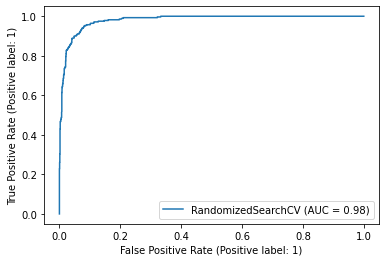

In [43]:
#plot the roc curve for Model A
metrics.plot_roc_curve(Model_A, X_test, y_test);

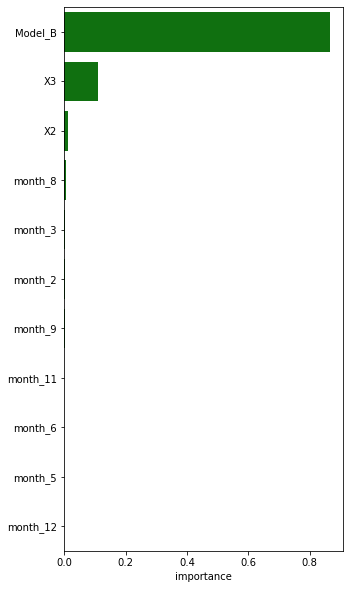

In [44]:
#examine feature importances

df_feature_importances = \
    pd.DataFrame(Model_A.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance']) \
        .sort_values(by='importance', ascending=False)


plt.figure(figsize=(5,10))
sns.barplot(data=df_feature_importances, y=df_feature_importances.index, x='importance', color='green', orient='h');

**Model A significantly relies on the output of Model B - this is by far the most important feature. However, X3 also had a fairly large contribution to the model. X2 and the month of August (month_8) also showed some importance. After, the top 4 features there was significant drop off in importance. It may be worth trying to build a model with only the top 4 features. This could lead to a simple, more robust, model.**

**SHAP Analysis**

In [56]:
#get SHAP values


X_test_sample = shap.sample(X_test,600)
explainer = shap.KernelExplainer(Model_A.predict, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)


Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/600 [00:00<?, ?it/s]

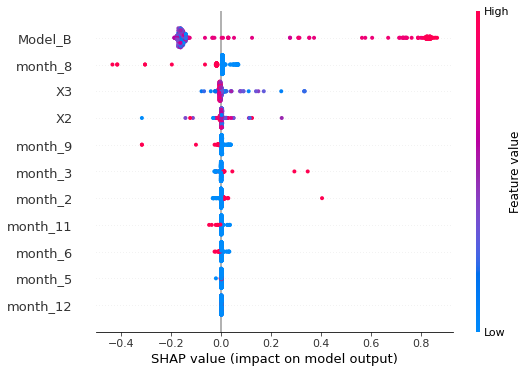

In [57]:
#create SHAP summary plot

shap.summary_plot(shap_values, X_test_sample)

## Part 3

In [45]:
#get the Model B predictions
Model_B_predictions = (X_test.Model_B > 0.5).astype(np.int64)

#get the Model A predictions
Model_A_predictions = Model_A.predict_proba(X_test)[:,1]
Model_A_predictions = (Model_A_predictions > 0.5).astype(np.int64)

In [46]:
#get the number and proportion of correct predictions for Model A vs. Model B
correct_model_A = (Model_A_predictions == y_test).sum()
correct_model_B = (Model_B_predictions == y_test).sum()

proportion_model_A = (Model_A_predictions == y_test).sum() / len(y_test)
proportion_model_B = (Model_B_predictions == y_test).sum() / len(y_test)

#DataFrame to hold correct prediction count
df_correct_count = pd.DataFrame(columns=['Model','Number Correct','Proportion Correct'])
df_correct_count = \
    df_correct_count.append(dict({'Model':'A', 'Number Correct': correct_model_A, 
                                 'Proportion Correct':proportion_model_A}), ignore_index=True)
df_correct_count = \
    df_correct_count.append(dict({'Model':'B', 'Number Correct': correct_model_B,
                                 'Proportion Correct':proportion_model_B}), ignore_index=True)

df_correct_count[['Model','Number Correct','Proportion Correct']]

,Model,Number Correct,Proportion Correct
0,A,1711,0.950556
1,B,1230,0.683333


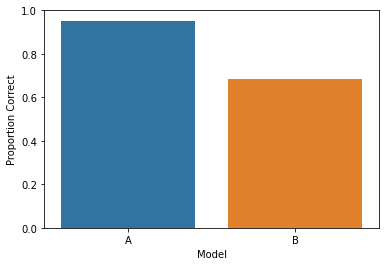

In [47]:
#plot the number correct for each model
sns.barplot(data=df_correct_count, x='Model', y='Proportion Correct');
plt.gca().set(ylim=(0,1));

**Model A showed significant improvment over Model B. Model A predicted 95% of the test cases correctly, while Model B predicted 68% of the test cases correctly. This indicates that the new features were relevant predictors and able to improve upon the Model B inputs.**

## Part 4

In [48]:
#create a dataframe to store model A predictions (probabilities) and actual values

#add model A predictions to the dataframe
df_actual_pred = pd.DataFrame(Model_A.predict_proba(X_test)[:,1])

#set the index based on y_test
df_actual_pred.index = y_test.index

#rename the predictions column
df_actual_pred.rename(columns={0:'Model_A_Prob'}, inplace=True)

#add the actual values to the dataframe
df_actual_pred['Actual'] = y_test

#sort the values by model A prediction (descending order)
df_actual_pred = df_actual_pred.sort_values(by='Model_A_Prob', ascending=False)

df_actual_pred.head()

,Model_A_Prob,Actual
2050,0.996696,1
3355,0.992761,1
3246,0.991680,1
3138,0.991090,1
2775,0.990711,1


In [49]:
#cut the dataframe into 10 equal sized buckets (based on Model A Predictions)
df_actual_pred['Bin'] = pd.qcut(df_actual_pred['Model_A_Prob'],10)

#group the data in order to inspect profit/loss for each bin/group
df_grouped_data = df_actual_pred.groupby('Bin').agg({'Actual':'sum', 'Model_A_Prob':'count'}) \
    .rename(columns={'Model_A_Prob':'Count', 'Actual':'Successes'})

#determine the cost of the emails and the value provided by the emails for each group/bin
df_grouped_data['Cost'] = df_grouped_data['Count'] * 0.01
df_grouped_data['Value'] = df_grouped_data['Successes'] * 0.25

#determine profit or loss for each group/bin
df_grouped_data['P/L'] = df_grouped_data['Value'] - df_grouped_data['Cost']

df_grouped_data

,Successes,Count,Cost,Value,P/L
Bin,,,,,
"(0.00021999999999999993, 0.00245]",0,180,1.80,0.00,-1.80
"(0.00245, 0.00295]",0,185,1.85,0.00,-1.85
"(0.00295, 0.00318]",0,176,1.76,0.00,-1.76
"(0.00318, 0.00351]",0,179,1.79,0.00,-1.79
"(0.00351, 0.00468]",0,180,1.80,0.00,-1.80
"(0.00468, 0.00687]",2,180,1.80,0.50,-1.30
"(0.00687, 0.021]",3,180,1.80,0.75,-1.05
"(0.021, 0.2]",18,180,1.80,4.50,2.70
"(0.2, 0.846]",89,180,1.80,22.25,20.45


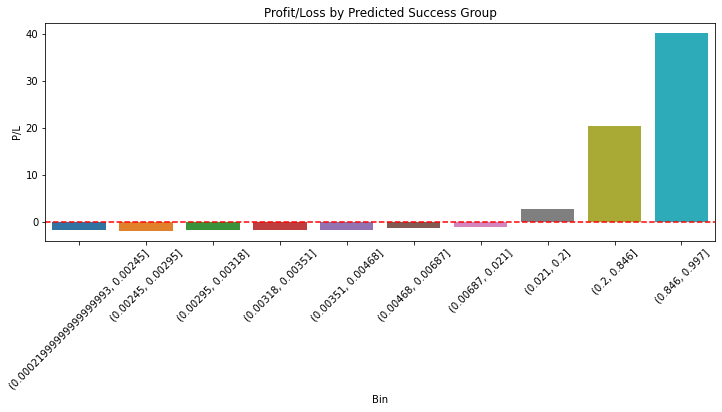

In [50]:
#plot the profit/loss by bin/group
plt.subplots(figsize=(12,4))
sns.barplot(data=df_grouped_data, x=df_grouped_data.index, y='P/L');
plt.gca().set_title('Profit/Loss by Predicted Success Group')
for label in plt.gca().get_xticklabels():
        label.set_rotation(45) 
        
#line to separate profit vs. loss
plt.gca().axhline(0, linestyle='--', color='red');

As expected, the groups with the highest predicted values (most likely to be a Success) provide the most value. Based on the above analysis, we should consider a predicted probability threshold of 0.021. Although, this is a low probability threshold, it is profitable to consider all emails with a Success probability above the threshold. This is because the revenue associated with a success is 25x the cost of the email. Therefore, even such a low probability threshold results in profitable email campaigns. 